## 5: Predictive model
Creating a predictive model using a grid search method (grid search)

#### Importing several libraries
Imports various libraries and modules used for data manipulation, analysis, plotting, machine learning, and other tasks.

In [111]:
# A library for data manipulation and analysis. 
# It provides data structures like DataFrames that allow to work with structured data efficiently.
import pandas as pd

# A library for numerical computations.
import numpy as np

# A plotting library that provides a wide range of functions for creating static, animated, and interactive visualizations.
from matplotlib import pyplot as plt

# A module that provides a way to interact with the operating system. It allows to perform operations like accessing files, directories, and environment variables.
import os

# This module provides various functions related to time, including measuring time intervals, delaying program execution, and working with timestamps.
import time

#  A library that provides methods for handling missing values in datasets.
from sklearn.impute import SimpleImputer

# Imports the SVR (Support Vector Regression) and SVC (Support Vector Classification) classes from the sklearn.svm module.
from sklearn.svm import SVR, SVC

# PolynomialFeatures is a class in scikit-learn (sklearn) that is used for feature engineering in machine learning.
# StandardScaler is class in the sklearn.preprocessing module that is used for standardizing features.
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# GridSearchCV is a class in scikit-learn (sklearn) that is used for hyperparameter tuning.
# GroupShuffleSplit is another class in the sklearn.model_selection module that is used for splitting data into train and test sets while preserving group structures.
from sklearn.model_selection import GridSearchCV, GroupShuffleSplit

# PCA is a dimensionality reduction technique used to transform high-dimensional data into a lower-dimensional space while preserving the most important information in the data.
from sklearn.decomposition import PCA

# The IsolationForest class in scikit-learn provides methods for fitting Isolation Forest models to data and predicting the anomaly scores for new data points.
from sklearn.ensemble import IsolationForest

# r2_score is a metric used to evaluate the performance of regression models.
from sklearn.metrics import r2_score

# The `FunctionSampler` class in imbalanced-learn is a transformer that applies a given function to the input data. 
from imblearn import FunctionSampler

# In scikit-learn, a pipeline is a sequence of data processing steps combined into a single object
from imblearn.pipeline import Pipeline as Pipeline

# A is a library that provides utilities for saving and loading Python objects, particularly large numerical arrays, efficiently.
from joblib import dump, load

# A module provides various functions for generating random numbers and performing random operations. 
import random

# A class that represents a decision tree model for regression tasks.
from sklearn.tree import DecisionTreeRegressor

#### Upload the proccessed data 
The uploading of the Excel files was actually in the second code file that dealt with the creation of the features.

In [68]:
run = '8'

# Read the Excel file of the train df into a DataFrame
file_path_train = f'data/train_features_df_run{run}.xlsx'
train_df = pd.read_excel(file_path_train)

# Read the Excel file of the test df into a DataFrame
file_path_test = f'data/test_features_df_run{run}.xlsx'
test_df = pd.read_excel(file_path_test)

#### Split the data sets to X & Y & subjects

In [75]:
def split_X_Y_Subjects(df):
    """
    Split the input DataFrame into separate data for subjects, predictors (X), and multiple outcomes (Y).

    Parameters:
        df (DataFrame): Input DataFrame containing the data.

    Returns:
        subjects (DataFrame): DataFrame containing the subject IDs.
        Y (DataFrame): DataFrame containing multiple outcome variables (MAP, L2_Change_MAP, L3_Ratio_MAP, L4_SBP, L5_DBP).
        X (DataFrame): DataFrame containing predictor variables after removing outcome and irrelevant columns.
        Y2 (array): Array containing the values of the L2_Change_MAP outcome variable.
        Y3 (array): Array containing the values of the L3_Ratio_MAP outcome variable.
        Y4 (array): Array containing the values of the L4_SBP outcome variable.
        Y5 (array): Array containing the values of the L5_DBP outcome variable.
        Y1_cat (array): Array containing categorized values of the MAP outcome variable (Critical_MAP_Category).
    """

    # Separate subject IDs
    subjects = df[['ID']]

    # Separate the multiple outcome variables (Y)
    Y = df[['MAP', 'L2_Change_MAP', 'L3_Ratio_MAP', 'L4_SBP', 'L5_DBP']]

    # Remove the outcome and irrelevant columns to get predictors (X)
    X = df.drop(['MAP', 'L2_Change_MAP', 'L3_Ratio_MAP', 'L4_SBP', 'L5_DBP', 'Part', 'ID', 'BP_type'], axis=1)

    # Flatten the outcome arrays (Y1, Y2, Y3, Y4, Y5) for later processing
    Y1 = Y[['MAP']].values.ravel()
    Y2 = Y[['L2_Change_MAP']].values.ravel()
    Y3 = Y[['L3_Ratio_MAP']].values.ravel()
    Y4 = Y[['L4_SBP']].values.ravel()
    Y5 = Y[['L5_DBP']].values.ravel()

    # Convert the L1_MAP outcome variable to categories (Critical_MAP_Category) based on certain thresholds
    # A value <= 70 is categorized as 0, between 70 and 80 as 0.5, and above 80 as 1.
    Critical_MAP_Category = [0 if (val <= 70) else 0.5 if (val > 70 and val <= 80) else 1 for val in Y1]
    Y1_cat = np.array(Critical_MAP_Category)

    return subjects, Y, X, Y2, Y3, Y4, Y5, Y1_cat

In [76]:
# Split the original train df to X & Y
subjects_train, Y_train, X_train, Y2_train, Y3_train, Y4_train, Y5_train, Y1_cat_train = split_X_Y_Subjects(train_df)

# Split the original test df to X & Y
subjects_test, Y_test, X_test, Y2_test, Y3_test, Y4_test, Y5_test, Y1_cat_test = split_X_Y_Subjects(test_df)

#### A, B: Removal of abnormal values from the set of features and labels

In [78]:
def outlier_rejection(X, y, percentile=1):
    """
    Perform outlier rejection based on the given percentile or using the Isolation Forest method.

    Parameters:
        X (array-like): The input feature matrix (predictors).
        y (array-like): The input target variable (outcomes).
        percentile (float or str): The percentile threshold for outlier rejection.
            If 'IsolationForest', the Isolation Forest method is used for outlier detection.
            If a float value between 0 and 100, it is used as the percentile threshold.

    Returns:
        X_rejected (array-like): The feature matrix after outlier rejection.
        y_rejected (array-like): The target variable after outlier rejection.
    """
    all_data = np.c_[X, y]

    if percentile == 'IsolationForest':
        print(f'IsolationForest', y.size)
        model = IsolationForest(max_samples=100, contamination=0.4)
        SI = SimpleImputer(missing_values=np.nan, strategy='mean')
        no_nan_all_data = SI.fit_transform(all_data)
        model.fit(no_nan_all_data)
        y_pred = model.predict(no_nan_all_data)
        bool_cond = y_pred == 1
    else:
        print(f'percentile={percentile}', y.size)
        hth = np.nanpercentile(all_data, 100 - percentile, axis=0)
        lth = np.nanpercentile(all_data, percentile, axis=0)
        bool_cond = np.prod((all_data < hth) * (all_data > lth), axis=1).astype('bool')

    # Return the data after outlier rejection
    return X[bool_cond], y[bool_cond]

#### F, G: Pipeline & GridSearchCV 
Grid search that incorporates cross-validation against 10 data sets, each consisting of 80% training and 20% test. This division was carried out using the Group Shuffle Split method which produces a number of predetermined random splits, where each of the splits contains a portion of the predetermined subgroups. In this case, the split was defined according to patient ID and labeling category so that in each group the percentage of different labeling was distributed similarly. In this way, the training and test data sets contain segments from different patients so that the model avoids overfitting.

#### SVM models

In [ ]:
# Creating the pipeline for regression
regressor_pipe_SVM = Pipeline([('Drop_Extreme_Values', FunctionSampler(func=outlier_rejection, validate=False)),  # Custom function for outlier rejection
                           ('Imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),  # Imputes missing values with 0
                           ('Standard Scaler', StandardScaler()),  # Standardizes the features by removing mean and scaling to unit variance
                           ('Dimension_reduction', PCA(svd_solver='full')),  # Principal Component Analysis for dimensionality reduction
                           ('estimator', SVR())])  # Support Vector Regression as the final estimator


# Creating the pipeline for classification
classifier_pipe_SVM = Pipeline([('Drop_Extreme_Values', FunctionSampler(func=outlier_rejection, validate=False)),  # Custom function for outlier rejection
                            ('Imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),  # Imputes missing values with 0
                            ('Standard Scaler', StandardScaler()),  # Standardizes the features by removing mean and scaling to unit variance
                            ('Dimension_reduction', PCA(svd_solver='full')),  # Principal Component Analysis for dimensionality reduction
                            ('estimator', SVC())])  # Support Vector Classifier as the final estimator


# Defining the Parameter Grid to be explored during the grid search of SVM model (regression & classification)
param_grid_SVM = [
    # First set of parameters for SVM with linear, sigmoid, and rbf kernels
       {'Drop_Extreme_Values__kw_args': [{'percentile': perc} for perc in ['IsolationForest', 0.01, 0.1, 1]],  # Percentile for outlier rejection
        'Dimension_reduction__n_components': [0.99, 0.999, 0.9999],  # Number of components to keep in PCA
        'estimator__C': np.logspace(-3, 2, 6),  # Regularization parameter for SVM
        'estimator__kernel': ['linear', 'sigmoid', 'rbf']},  # Kernels to be used in SVM
    
    # Second set of parameters for SVM with poly kernel
       {'Drop_Extreme_Values__kw_args': [{'percentile': perc} for perc in ['IsolationForest', 0.01, 0.1, 1]],  # Percentile for outlier rejection
        'Dimension_reduction__n_components': [0.99, 0.999, 0.9999, 0.99999],  # Number of components to keep in PCA
        'estimator__C': np.logspace(-3, 2, 11),  # Regularization parameter for SVM
        'estimator__kernel': ['poly'],  # Using polynomial kernel for SVM
        'estimator__degree': [2, 3, 4, 6]}]  # Degree of the polynomial kernel

#### Decision tree models

In [ ]:
# Creating the pipeline for regression
regressor_pipe_DT = Pipeline([('Drop_Extreme_Values', FunctionSampler(func=outlier_rejection, validate=False)),  # Custom function for outlier rejection
                            ('Imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),  # Imputes missing values with 0
                            ('Standard Scaler', StandardScaler()),  # Standardizes the features by removing mean and scaling to unit variance
                            ('Dimension_reduction', PCA(svd_solver='full')),  # Principal Component Analysis for dimensionality reduction
                            ('estimator', DecisionTreeRegressor())])  # Decision Tree Regressor as the final estimator


# Creating the pipeline for classification
classifier_pipe_DT = Pipeline([('Drop_Extreme_Values', FunctionSampler(func=outlier_rejection, validate=False)),  # Custom function for outlier rejection
                            ('Imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),  # Imputes missing values with 0
                            ('Standard Scaler', StandardScaler()),  # Standardizes the features by removing mean and scaling to unit variance
                            ('Dimension_reduction', PCA(svd_solver='full')),  # Principal Component Analysis for dimensionality reduction
                            ('estimator', DecisionTreeClassifier())])  # Decision Tree Classifier as the final estimator


# Defining the Parameter Grid to be explored during the grid search
param_grid_DT = [{'Drop_Extreme_Values__kw_args': [{'percentile': perc} for perc in ['IsolationForest', 0.01, 0.1, 1]],  # Percentile for outlier rejection
               'Dimension_reduction__n_components': [0.99, 0.999, 0.9999],  # Number of components to keep in PCA
               'estimator__max_depth': [None, 2, 5, 10, 20, 50],  # Maximum depth of the decision tree
               'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
               'estimator__min_samples_leaf': [1, 2, 4, 8]}]  # Minimum number of samples required to be at a leaf node

#### Perform grid search, model fitting, and evaluation using cross-validation

In [ ]:
def fit_grid(X_train, X_test, y_train, y_test, subjects, pipe, param_grid, title, test_size=0.15, n_splits=10, scoring="r2"):
    """
    Perform grid search, model fitting, and evaluation using cross-validation.

    Parameters:
        X_train (array-like): The training feature matrix.
        X_test (array-like): The testing feature matrix.
        y_train (array-like): The training target variable.
        y_test (array-like): The testing target variable.
        subjects (array-like): The array containing subject IDs for grouping during cross-validation.
        pipe (Pipeline): The sklearn pipeline containing the model to be optimized.
        param_grid (dict or list of dicts): The parameter grid to be explored during grid search.
        title (str): The title used for saving the results and plots.
        test_size (float, optional): The proportion of test data during cross-validation split. Default is 0.15.
        n_splits (int, optional): The number of cross-validation splits. Default is 10.
        scoring (str, optional): The scoring method used for model evaluation. Default is "r2".

    Returns:
        grid (GridSearchCV): The fitted GridSearchCV object.
        gridFrame (DataFrame): The DataFrame containing the results of the grid search.
    """

    start_time = time.time()

    # Split the train data into multiple splits with 20% test and 80% train based on the subject IDs
    cv_splitter = GroupShuffleSplit(test_size=test_size, n_splits=n_splits)
    split = cv_splitter.split(X_train, groups=subjects)

    # Perform grid search with cross-validation
    grid = GridSearchCV(pipe, param_grid, cv=split, return_train_score=True, scoring=scoring, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Save the best model from the grid search
    filename = os.path.join('Results', title + '_grid_model.sav')
    dump(grid.best_estimator_, filename)

    # Print the best parameters found during the grid search
    print(grid.best_params_)

    # Store the results of the grid search in a DataFrame
    gridFrame = pd.DataFrame(grid.cv_results_)

    # Save the grid search results to a CSV file
    filename = os.path.join('Results', title + '_Table_Results.csv')
    gridFrame.to_csv(filename)

    # Calculate the valid ranges of numbers to compute the score
    # based on the title of the outcome variable (e.g., SBP, DBP)
    if (title == 'SBP') or (title == 'DBP'):
        min_val_train = min_val_test = 10
        max_val_train = max_val_test = 290
    elif title == 'Change_MAP':
        min_val_train = 10 - X_train['BaseLine_MAP']
        max_val_train = 290 - X_train['BaseLine_MAP']
        min_val_test = 10 - X_test['BaseLine_MAP']
        max_val_test = 290 - X_test['BaseLine_MAP']
    elif title == 'Ratio_MAP':
        min_val_train = 10 / X_train['BaseLine_MAP']
        max_val_train = 290 / X_train['BaseLine_MAP']
        min_val_test = 10 / X_test['BaseLine_MAP']
        max_val_test = 290 / X_test['BaseLine_MAP']

    # Plot the predicted and true values for train and test datasets
    plt.figure(figsize=(10, 8))

    plt.subplot(211)
    y_hat_train = grid.predict(X_train)
    ind_train = (y_hat_train > min_val_train) & (y_hat_train < max_val_train)
    plt.plot(y_train, label='y_train_true')
    plt.plot(y_hat_train, label='y_train_pred')
    if scoring == "r2":
        plt.title(f'Train: {title} r2 scoring {r2_score(y_train[ind_train], y_hat_train[ind_train]):.3f}')
    elif scoring == "f1":
        score_f1_train = f1_score(y_train[ind_train], y_hat_train[ind_train], average='weighted')
        plt.title(f'Train: {title} f1 scoring {score_f1_train:.3f}')
    plt.legend(loc='upper right')

    plt.subplot(212)
    y_hat_test = grid.predict(X_test)
    ind_test = np.where((y_hat_test > min_val_test) & (y_hat_test < max_val_test))
    plt.plot(y_test, label='y_test_true')
    plt.plot(y_hat_test, label='y_test_pred')
    if scoring == "r2":
        plt.title(f'Test: {title} r2 scoring {r2_score(y_test[ind_test], y_hat_test[ind_test]):.3f}')
    elif scoring == "f1":
        score_f1_test = f1_score(y_test[ind_test], y_hat_test[ind_test], average='weighted')
        plt.title(f'Test: {title} f1 scoring {score_f1_test:.3f}')
    plt.legend(loc='upper right')

    # Save the plot
    filename = os.path.join('Results', title)
    plt.savefig(filename)

    end_time = time.time()
    print(f'Execution time: {end_time - start_time:.0f} sec')

    return grid, gridFrame

#### Runnig the SVM predictive model on all the different labels

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
29460 fits failed out of a total of 33920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13380 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Anaconda3\lib\site-packages\joblib\memory.py", line 

IsolationForest 3360
{'Dimension_reduction__n_components': 0.99, 'Drop_Extreme_Values__kw_args': {'percentile': 'IsolationForest'}, 'estimator__C': 0.001, 'estimator__kernel': 'linear'}
Execute time 6386 sec


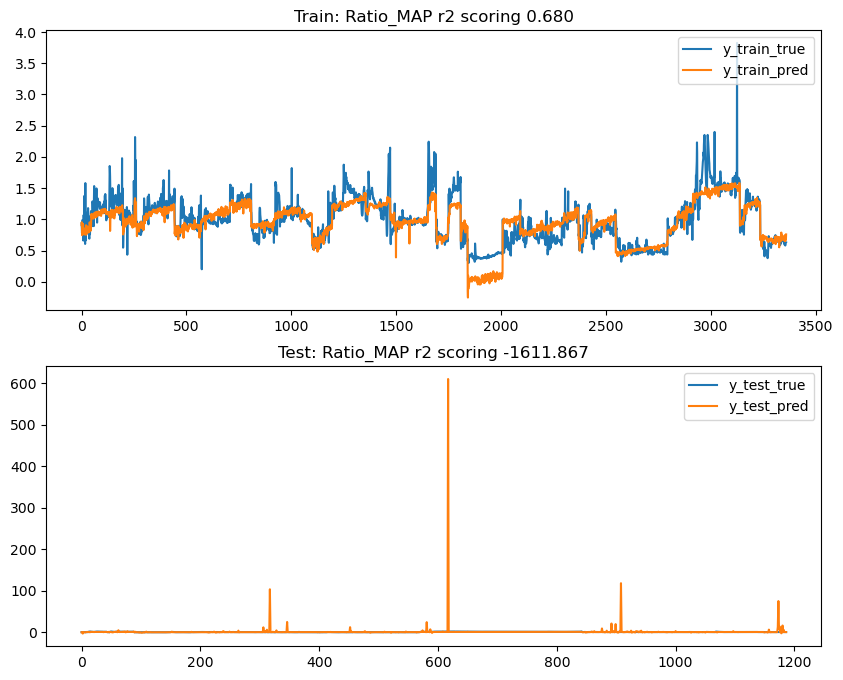

In [105]:
# Regression SVM model predict Ratio_MAP
regressor_grid_3, regressor_gridFrame_3 = fit_grid(X_train, X_test, Y3_train, Y3_test, subjects_train,
                                                   regressor_pipe_SVM, param_grid_SVM, 'Ratio_MAP')

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
29460 fits failed out of a total of 33920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13380 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Anaconda3\lib\site-packages\joblib\memory.py", line 

IsolationForest 3360
{'Dimension_reduction__n_components': 0.99, 'Drop_Extreme_Values__kw_args': {'percentile': 'IsolationForest'}, 'estimator__C': 1.0, 'estimator__kernel': 'linear'}
Execute time 2312 sec


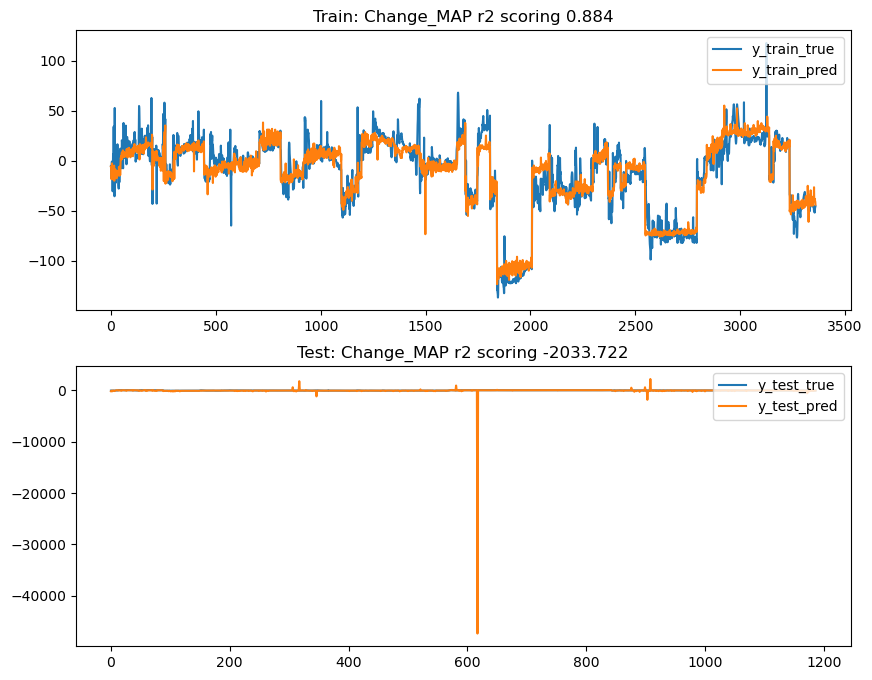

In [106]:
# Regression SVM model predict Change_MAP
regressor_grid_2, regressor_gridFrame_2 = fit_grid(X_train, X_test, Y2_train, Y2_test, subjects_train,
                                                   regressor_pipe_SVM, param_grid_SVM, 'Change_MAP')

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
29460 fits failed out of a total of 33920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13380 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Anaconda3\lib\site-packages\joblib\memory.py", line 

IsolationForest 3360
{'Dimension_reduction__n_components': 0.99, 'Drop_Extreme_Values__kw_args': {'percentile': 'IsolationForest'}, 'estimator__C': 10.0, 'estimator__kernel': 'rbf'}
Execute time 1323 sec


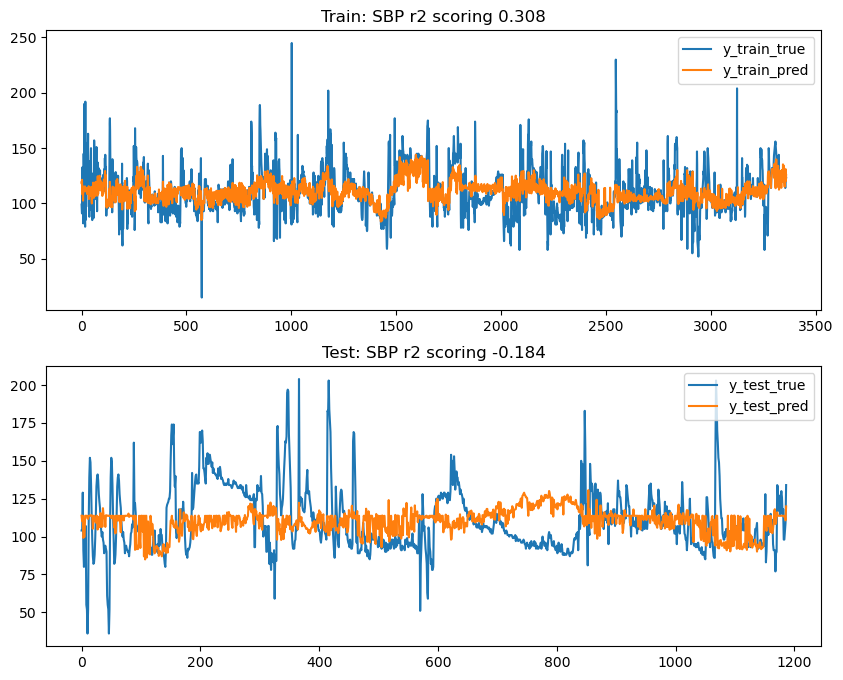

In [108]:
# Regression SVM model predict SBP
regressor_grid_4, regressor_gridFrame_4 = fit_grid(X_train, X_test, Y4_train, Y4_test, subjects_train,
                                                   regressor_pipe_SVM, param_grid_SVM, 'SBP')

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
29460 fits failed out of a total of 33920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13380 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 240, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Anaconda3\lib\site-packages\joblib\memory.py", line 

IsolationForest 3360
{'Dimension_reduction__n_components': 0.999, 'Drop_Extreme_Values__kw_args': {'percentile': 'IsolationForest'}, 'estimator__C': 0.01, 'estimator__kernel': 'sigmoid'}
Execute time 1422 sec


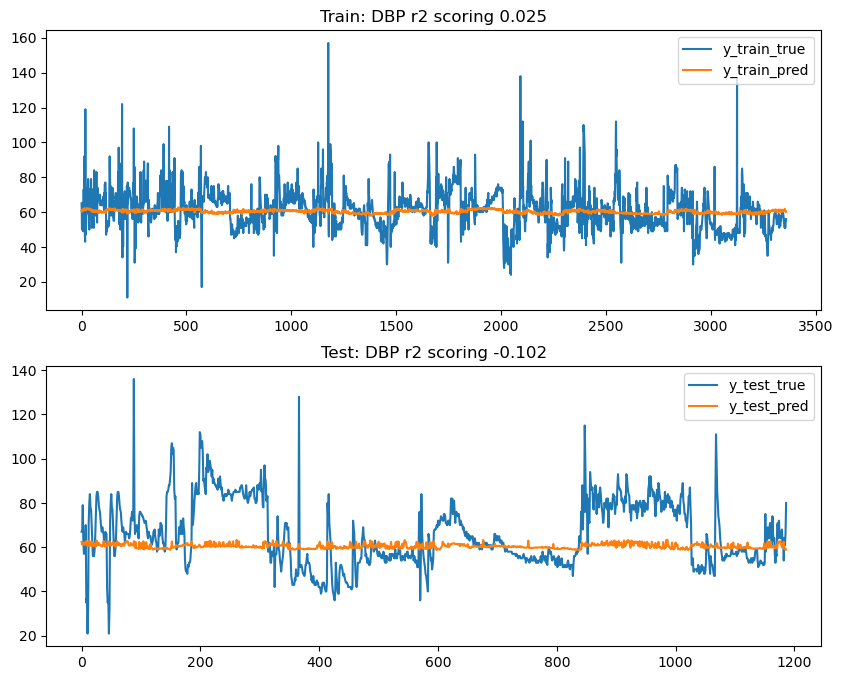

In [109]:
# Regression SVM model predict DBP
regressor_grid_5, regressor_gridFrame_5 = fit_grid(X_train, X_test, Y5_train, Y5_test, subjects_train,
                                                   regressor_pipe_SVM, param_grid_SVM, 'DBP')

In [1]:
# Classification SVM model
classifier_grid_cat, classifier_gridFrame_cat = fit_grid(X_train, X_test, Y1_cat_train, Y1_cat_test, subjects_train,
                                                   classifier_pipe_SVM, param_grid_SVM, 'MAP_ThresHold')

NameError: name 'fit_grid' is not defined

#### R2 evaluation on DMAP predict
Evaluation indices were considered based on the r2 index which measures the sum of the squared model error to a large number of squared naive model error

In [ ]:
# Load the saved regression model from the specified file
file_name = r'Results\Change_MAP_grid_model.sav'
loaded_model2 = load(file_name)

# Predict the target variable (Y2) for the training and test data using the loaded model
y2_hat_train = loaded_model2.predict(X_train)
y2_hat_test = loaded_model2.predict(X_test)

# R2 calculation for the training data
# Add the predicted values to the subjects_train DataFrame
subjects_train['y2_hat_train'] = y2_hat_train

# Calculate the average predicted value for each ID group in the training data
average_bp_train = subjects_train.groupby('ID')['y2_hat_train'].mean()

# Map the 'ID'-wise average predictions to the respective rows in subjects_train DataFrame
subjects_train['Average_BP_by_ID'] = subjects_train['ID'].map(average_bp_train)

# Extract the actual target variable values (Y2_train) and the predicted values (y2_hat_train) from the DataFrame
d_m_train = subjects_train['Average_BP_by_ID'].values
d_hat_train = subjects_train['y2_hat_train'].values
d_train = Y2_train

# Calculate two alternative versions of R2 (R-squared) metrics for the training data
R2_2_train = 1 - (np.sum((d_train - d_hat_train) ** 2) / np.sum((d_train - d_m_train) ** 2))
R2_3_train = 1 - (np.sum((d_train - d_hat_train) ** 2) / np.sum(d_train ** 2))

# Print the original R2 score and the two alternative R2 scores for the training data
print(f'Train: original R2: {r2_score(Y2_train, y2_hat_train)}, our R2 version 2: {R2_2_train}, our R2 version 3: {R2_3_train}')

# R2 calculation for the test data
# Add the predicted values to the subjects_test DataFrame
subjects_test['y2_hat_test'] = y2_hat_test

# Calculate the average predicted value for each ID group in the test data
average_bp_test = subjects_test.groupby('ID')['y2_hat_test'].mean()

# Map the 'ID'-wise average predictions to the respective rows in subjects_test DataFrame
subjects_test['Average_BP_by_ID'] = subjects_test['ID'].map(average_bp_test)

# Extract the actual target variable values (Y2_test) and the predicted values (y2_hat_test) from the DataFrame
d_m_test = subjects_test['Average_BP_by_ID'].values
d_hat_test = subjects_test['y2_hat_test'].values
d_test = Y2_test

# Calculate two alternative versions of R2 (R-squared) metrics for the test data
R2_2_test = 1 - (np.sum((d_test - d_hat_test) ** 2) / np.sum((d_test - d_m_test) ** 2))
R2_3_test = 1 - (np.sum((d_test - d_hat_test) ** 2) / np.sum(d_test ** 2))

# Print the original R2 score and the two alternative R2 scores for the test data
print(f'Test: original R2: {r2_score(Y2_test, y2_hat_test)}, our R2 version 2: {R2_2_test}, our R2 version 3: {R2_3_test}')

#### Runnig the Decision tree predictive model on all the different labels

In [ ]:
# Regression Decision tree model predict Ratio_MAP
regressor_grid_3, regressor_gridFrame_3 = fit_grid(X_train, X_test, Y3_train, Y3_test, subjects_train,
                                                   regressor_pipe_DT, param_grid_DT, 'Ratio_MAP')

In [ ]:
# Regression Decision tree model predict Change_MAP
regressor_grid_2, regressor_gridFrame_2 = fit_grid(X_train, X_test, Y2_train, Y2_test, subjects_train,
                                                   regressor_pipe_DT, param_grid_DT, 'Change_MAP')

In [ ]:
# Regression Decision tree model predict SBP
regressor_grid_4, regressor_gridFrame_4 = fit_grid(X_train, X_test, Y4_train, Y4_test, subjects_train,
                                                   regressor_pipe_DT, param_grid_DT, 'SBP')

In [ ]:
# Regression Decision tree model predict DBP
regressor_grid_5, regressor_gridFrame_5 = fit_grid(X_train, X_test, Y5_train, Y5_test, subjects_train,
                                                   regressor_pipe_DT, param_grid_DT, 'DBP')

In [ ]:
# Classification Decision tree model
classifier_grid_cat, classifier_gridFrame_cat = fit_grid(X_train, X_test, Y1_cat_train, Y1_cat_test, subjects_train,
                                                   classifier_pipe_DT, param_grid_DT, 'MAP_ThresHold')

#### Visualization of SVM models

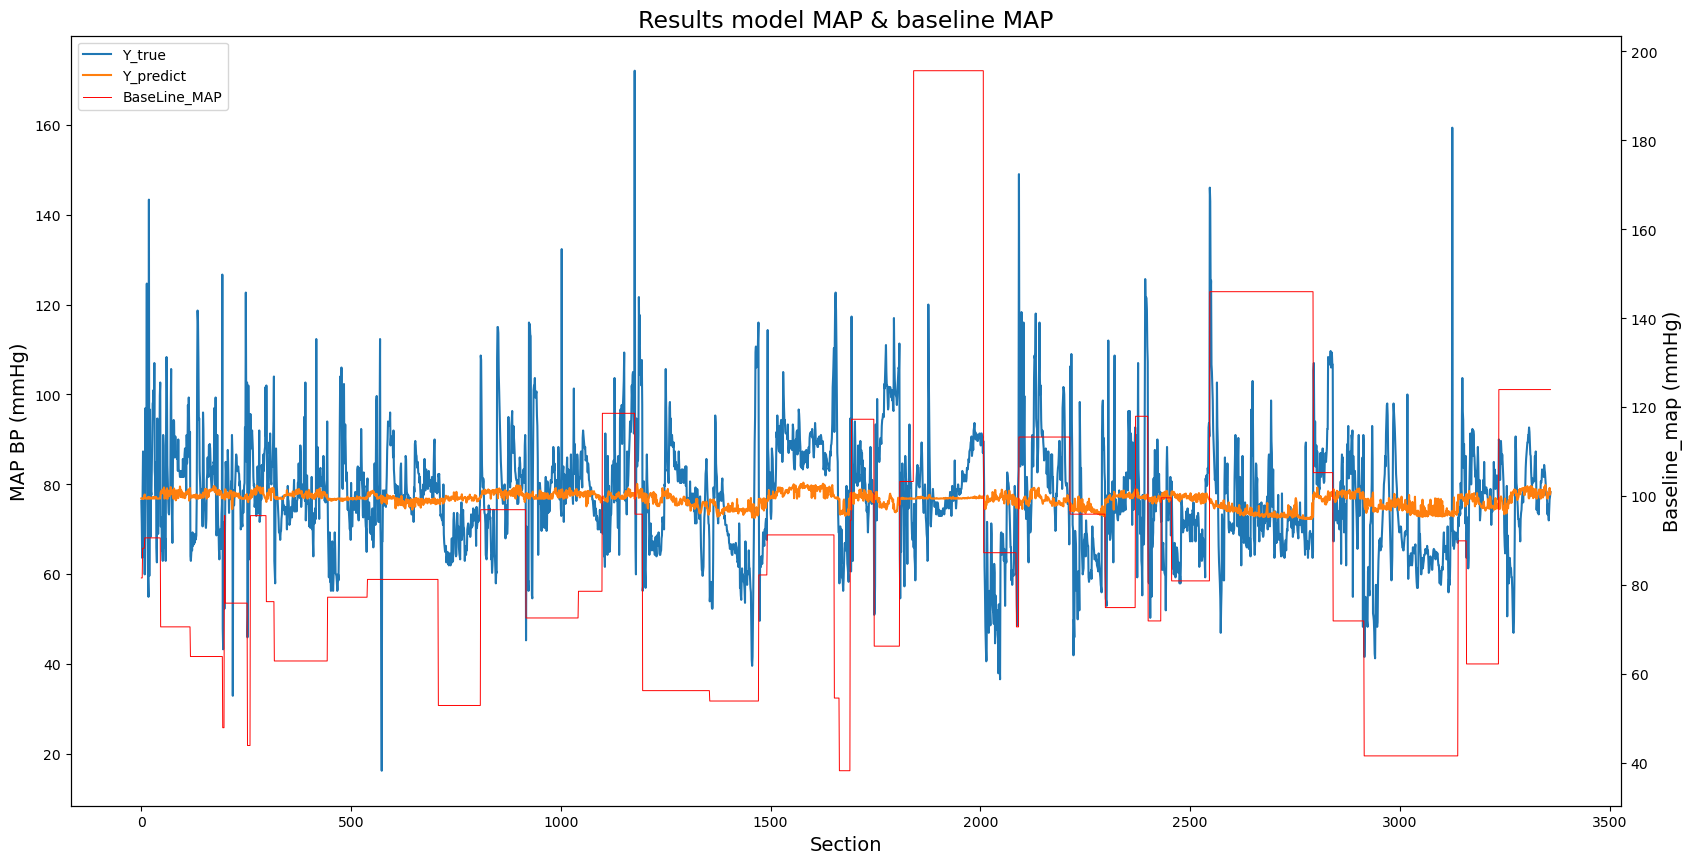

In [177]:
file_name = r'Results\Change_MAP_grid_model.sav'
loaded_model1 = load(file_name)

# Use the loaded model to predict the Change_MAP values for the training set
y1_hat_train = loaded_model1.predict(X_train)

# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot the true values (Y_true) and the predicted values (Y_predict) for Change_MAP on the first y-axis (ax1)
Y_true, = ax1.plot(Y1_train, label='Y_true')
Y_predict, = ax1.plot(y1_hat_train, label='Y_predict')

# Set labels and title for the plot
ax1.set_title('Train results model DMAP & baseline MAP', size=17)
ax1.set_ylabel('DMAP (mmHg)', size=14)
ax1.set_xlabel('Section', size=14)

# Create a second y-axis (ax2) and plot the baseline MAP values on it
ax2 = ax1.twinx()
ax2.set_ylabel('Baseline_map (mmHg)', size=14)
ax2.plot(X_train['BaseLine_MAP'].values, color='r', linestyle='-', linewidth=0.7)

# Create legend handles and labels to display on the plot
legend_handles = [Y_true, Y_predict, ax2.lines[0]]
legend_labels = ['Y_true', 'Y_predict', 'BaseLine_MAP']
ax2.legend(handles=legend_handles, labels=legend_labels, loc='upper left')

# Show the plot
plt.show()

#### Visualization of the category distribution

In [ ]:
# Calculate unique values and their respective counts for each category in the training dataset
unique_values_train, counts_train = np.unique(Y1_cat_train, return_counts=True)
# Calculate the percentage of each category in the training dataset
percentages_train = (counts_train / len(Y1_cat_train)) * 100

# Calculate unique values and their respective counts for each category in the test dataset
unique_values_test, counts_test = np.unique(Y1_cat_test, return_counts=True)
# Calculate the percentage of each category in the test dataset
percentages_test = (counts_test / len(Y1_cat_test)) * 100

# Create an array of category indices
categories = np.arange(len(percentages_train))
# Set the width of each bar in the grouped bar chart
width = 0.35

# Create the figure for the plot
plt.figure(figsize=(5, 3))

# Plot the percentages of each category for the training dataset as a bar
plt.bar(categories, percentages_train, width, label='Train')

# Plot the percentages of each category for the test dataset as a bar, stacked on top of the training dataset bars
plt.bar(categories, percentages_test, width, label='Test', bottom=percentages_train)

# Set labels and title for the plot
plt.xlabel('Category', size=12)
plt.ylabel('Percentage [%]', size=12)
plt.title('Category Distribution')
plt.xticks(categories)

# Add legend to the plot
plt.legend()

# Add text labels on top of the bars showing the percentages for both training and test datasets
for i in range(len(categories)):
    plt.text(categories[i], percentages_train[i] / 2, f'{round(percentages_train[i], 1)}%', ha='center', va='center')
    plt.text(categories[i], percentages_train[i] + (percentages_test[i] / 2), f'{round(percentages_test[i], 1)}%', ha='center', va='center')

# Show the plot
plt.show()